In [6]:
pip install tensorflow emnist


Epoch 1/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6052 - loss: 1.3433 - val_accuracy: 0.8383 - val_loss: 0.5119
Epoch 2/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8300 - loss: 0.5450 - val_accuracy: 0.8689 - val_loss: 0.3997
Epoch 3/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8651 - loss: 0.4258 - val_accuracy: 0.8776 - val_loss: 0.3698
Epoch 4/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8762 - loss: 0.3763 - val_accuracy: 0.8839 - val_loss: 0.3490
Epoch 5/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8881 - loss: 0.3383 - val_accuracy: 0.8932 - val_loss: 0.3278
Epoch 6/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8942 - loss: 0.3122 - val_accuracy: 0.8958 - val_loss: 0.3130
Epoch 7/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9005 - loss: 0.2947 - val_accuracy: 0.8951 - val_loss: 0.3218
Epoch 8/10
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9032 - loss: 0.2817 - val_accuracy: 0.

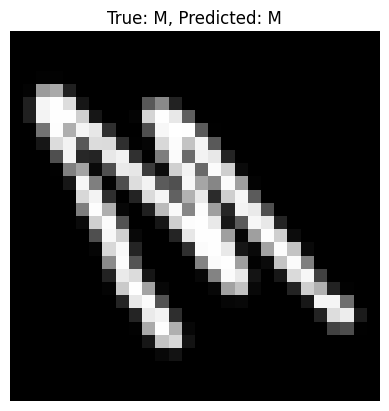

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load EMNIST letters split
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Fix image orientation (rotate 90 degrees CW and flip vertically)
def fix_orientation(image):
    image = tf.image.transpose(image)  # rotate 90 deg
    image = tf.image.flip_left_right(image)  # correct mirror flip
    return image

# Normalize and preprocess
def preprocess(image, label):
    image = fix_orientation(image)
    image = tf.cast(image, tf.float32) / 255.0
    label -= 1  # Labels are 1–26 → Shift to 0–25
    return image, label

batch_size = 128
ds_train = ds_train.map(preprocess).shuffle(10_000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(26, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(ds_train, validation_data=ds_test, epochs=10)

# Evaluate the model
model.evaluate(ds_test)

# Visualize a sample prediction
for image_batch, label_batch in ds_test.take(1):
    pred = model.predict(image_batch[:1])
    plt.imshow(tf.squeeze(image_batch[0]), cmap='gray')
    plt.title(f"True: {chr(label_batch[0].numpy() + 65)}, Predicted: {chr(tf.argmax(pred[0]).numpy() + 65)}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted: T (Confidence: 1.00)


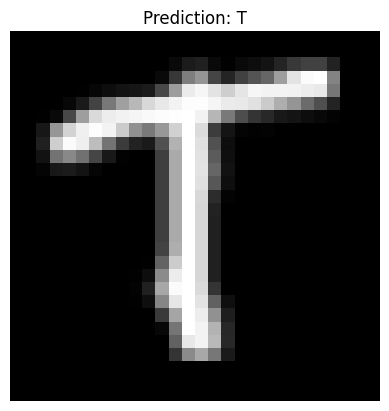

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def predict_emnist_image(model, img_path):
    # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resize to 28x28
    img = cv2.resize(img, (28, 28))

    # Invert if background is white
    if np.mean(img) > 127:
        img = 255 - img

    # Normalize
    img = img / 255.0

    # Expand dimensions to (1, 28, 28, 1)
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    # Predict
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    confidence = np.max(predictions)

    # Convert class index (0–25) to A–Z
    predicted_letter = chr(predicted_class + 65)

    # Display
    print(f"Predicted: {predicted_letter} (Confidence: {confidence:.2f})")

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Prediction: {predicted_letter}")
    plt.axis('off')
    plt.show()

# Example usage:
predict_emnist_image(model, "/content/drive/MyDrive/t.png")


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
